In [1]:
import sys
sys.path.append("/n/home12/binxuwang/Github/Neuro-ActMax-GAN-comparison")
import torch
import numpy as np
import os
from os.path import join
from tqdm import tqdm, trange
from PIL import Image
import pickle as pkl
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
from core.utils.dataset_utils import ImagePathDataset, normalizer, denormalizer, ImageDataset_filter
from core.utils.plot_utils import saveallforms
from neuro_data_analysis.neural_data_lib import load_img_resp_pairs_multiwindow, load_neural_data # load_img_resp_pairs_multiwindow
# from CorrFeatTsr_lib import Corr_Feat_Machine, visualize_cctsr, loadimg_preprocess
# from core.utils.layer_hook_utils import featureFetcher_module
# from core.utils.CNN_scorers import TorchScorer, load_featnet
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [2]:
import platform
if platform.system() == "Windows":
    stim_rootdir = "S:"
    device = "cuda"
elif platform.system() == "Darwin":
    stim_rootdir = "/Users/binxuwang/Network_mapping"
    device = "mps"
elif platform.system() == "Linux":
    stim_rootdir = "/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Datasets"
    stim_rootdir = "/n/holyscratch01/kempner_fellows/Users/binxuwang/Datasets"
    device = "cuda"

# load the neural data
BFEStats_merge, BFEStats = load_neural_data()
rsp_wdws = [range(50, 200), range(0, 50), range(50, 100), range(100, 150), range(150, 200)]


In [3]:
embed_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')

Using cache found in /n/holylabs/LABS/kempner_fellows/Users/binxuwang/torch_cache/hub/facebookresearch_dinov2_main
/n/holylabs/LABS/kempner_fellows/Users/binxuwang/torch_cache/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/n/holylabs/LABS/kempner_fellows/Users/binxuwang/torch_cache/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/n/holylabs/LABS/kempner_fellows/Users/binxuwang/torch_cache/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [4]:
def embed_imgs(imgfps, embed_model, batch_size=100, size=224, device="cuda", num_workers=8):
    dataset = ImagePathDataset(imgfps, transform=transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        normalizer,
    ]))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    embed_model = embed_model.to(device)
    embed_model.eval()
    embeddings = []
    for batch, _ in tqdm(dataloader):
        with torch.no_grad():
            embed_vec = embed_model(batch.to(device))
        embeddings.append(embed_vec)
    embeddings = torch.cat(embeddings, dim=0).detach().cpu()
    return embeddings, dataset


def embed_dataset(dataset, embed_model, batch_size=100, size=224, device="cuda", num_workers=8):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    embed_model = embed_model.to(device)
    embed_model.eval()
    embeddings = []
    for batch in tqdm(dataloader):
        assert batch.shape[2] == batch.shape[3] == size
        with torch.no_grad():
            embed_vec = embed_model(batch.to(device))
        embeddings.append(embed_vec.detach().cpu())
    embeddings = torch.cat(embeddings, dim=0)
    return embeddings

In [ ]:
BFEStats[1]["meta"]

## Compute DINO Embeddings

### BigGAN Evolution image embedding

In [8]:
embed_root = "/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/BigGAN_img_embedding"
embed_dir = join(embed_root, "dinov2_vitb14")
os.makedirs(embed_dir, exist_ok=True)

In [ ]:
num_workers = 8
for Expi in trange(63, 1 + 190):
    if BFEStats[Expi-1]["evol"] is None:
        print(f"Exp {Expi} is None")
        continue
    try:
        imgfps0, resp_mat0, gen_vec0 = load_img_resp_pairs_multiwindow(BFEStats, Expi,
                            "Evol", thread=0, stimdrive=stim_rootdir,
                            output_fmt="vec", rsp_wdws=rsp_wdws)
        imgfps1, resp_mat1, gen_vec1 = load_img_resp_pairs_multiwindow(BFEStats, Expi,
                            "Evol", thread=1, stimdrive=stim_rootdir,
                            output_fmt="vec", rsp_wdws=rsp_wdws)
    except IndexError or FileNotFoundError:
        print(f"File missing for Exp {Expi}")
        continue
    if len(imgfps0) == 0 or len(imgfps1) == 0:
        continue
    embeddings0, dataset0 = embed_imgs(imgfps0, embed_model, batch_size=100, size=224, device=device, num_workers=num_workers)
    embeddings1, dataset1 = embed_imgs(imgfps1, embed_model, batch_size=100, size=224, device=device, num_workers=num_workers)
    embed_act_dict = {
        "embeddings0": embeddings0,
        "embeddings1": embeddings1,
        "imgfps0": imgfps0,
        "imgfps1": imgfps1,
        "resp_mat0": resp_mat0,
        "resp_mat1": resp_mat1,
        "gen_vec0": gen_vec0,
        "gen_vec1": gen_vec1,
    }
    pkl.dump(embed_act_dict, open(join(embed_dir, f"Exp{Expi:03d}_embed_act_data.pkl"), "wb"))
    print(f"Exp {Expi} done. saved to {embed_dir}")


### ImageNet Embedding

In [ ]:
from core.utils.dataset_utils import create_imagenet_valid_dataset
rootdir = r"/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Datasets/imagenet-valid"
INdataset = create_imagenet_valid_dataset(imgpix=224,rootdir=rootdir)
dataloaders = DataLoader(INdataset, batch_size=256, shuffle=False, num_workers=8)

In [ ]:
# show the image
img, score = INdataset[1]
plt.imshow(denormalizer(img).permute(1, 2, 0))
plt.title(score)

In [ ]:
embed_model.cuda().eval()
embedding_col = []
for batch, _ in tqdm(dataloaders):
    with torch.no_grad():
        embed_vec = embed_model(batch.cuda())
    embedding_col.append(embed_vec.detach().cpu())

embedding_mat = torch.cat(embedding_col, dim=0)
pkl.dump(embedding_mat, open(join(embed_dir, "imagenet_valid_embedding.pkl"), "wb"))

### GAN reference image embedding

In [101]:
from core.utils.dataset_utils import ImageDataset_filter
GANimgroot = join(stim_rootdir, "GAN_sample_fid")
os.listdir(GANimgroot)

['BigGAN_trunc07',
 'resnet50_linf8_gradevol_avgpool',
 'DeePSim_4std',
 'resnet50_linf8_gradevol_layer3',
 'resnet50_linf8_gradevol',
 'pink_noise',
 'BigGAN_1000cls_std07_invert',
 'yolo_summary',
 'yolo_objconf_summary',
 'BigGAN_std_008',
 'resnet50_linf8_gradevol_layer4']

In [102]:
default_tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalizer,
])

In [20]:
imgroot = join(GANimgroot, "BigGAN_1000cls_std07_invert")
FCinvertdataset = ImageDataset_filter(imgroot, glob_pattern="FC_invert*", 
                            transform=default_tfm)
BGorigdataset = ImageDataset_filter(imgroot, glob_pattern="BG*", 
                            transform=default_tfm)
BGBlurdataset = ImageDataset_filter(imgroot, glob_pattern="BG*",
                            transform=transforms.Compose([
                               transforms.ToTensor(), 
                               transforms.GaussianBlur([15, 15], sigma=9),
                               transforms.Resize((224, 224)),
                               normalizer,]))
print(len(FCinvertdataset), len(BGorigdataset), len(BGBlurdataset))

imageset_str = "DeePSim_4std"
FCdataset = ImageDataset_filter(join(GANimgroot, "DeePSim_4std"), 
                    glob_pattern="sample*", transform=default_tfm)
print(imageset_str, len(FCdataset))
imageset_str = "BigGAN_trunc07"
BGdataset = ImageDataset_filter(join(GANimgroot, "BigGAN_trunc07"), 
                    glob_pattern="sample*", transform=default_tfm)
print(imageset_str, len(BGdataset))
imageset_str = "BigGAN_std_008"
BGRNDdataset = ImageDataset_filter(join(GANimgroot, "BigGAN_std_008"), 
                    glob_pattern="sample*", transform=default_tfm)
print(imageset_str, len(BGRNDdataset))

imageset_str = "resnet50_linf8_gradevol"
gradevoldataset_fc = ImageDataset_filter(join(GANimgroot, "resnet50_linf8_gradevol"), 
                    glob_pattern="class*", transform=default_tfm)
print(imageset_str, len(gradevoldataset_fc))
imageset_str = "resnet50_linf8_gradevol_avgpool"
gradevoldataset_avgpool = ImageDataset_filter(join(GANimgroot, "resnet50_linf8_gradevol_avgpool"), 
                    glob_pattern="class*", transform=default_tfm)
print(imageset_str, len(gradevoldataset_avgpool))
imageset_str = "resnet50_linf8_gradevol_layer4"
gradevoldataset_layer4 = ImageDataset_filter(join(GANimgroot, "resnet50_linf8_gradevol_layer4"), 
                    glob_pattern="class*", transform=default_tfm)
print(imageset_str, len(gradevoldataset_layer4))
imageset_str = "resnet50_linf8_gradevol_layer3"
gradevoldataset_layer3 = ImageDataset_filter(join(GANimgroot, "resnet50_linf8_gradevol_layer3"), 
                    glob_pattern="class*", transform=default_tfm)
print(imageset_str, len(gradevoldataset_layer3))

21000 21000 21000
DeePSim_4std 50000
BigGAN_trunc07 50000
BigGAN_std_008 50000
resnet50_linf8_gradevol 50000
resnet50_linf8_gradevol_avgpool 51200
resnet50_linf8_gradevol_layer4 51200
resnet50_linf8_gradevol_layer3 51200


In [ ]:
num_workers = 8
device = "cuda"
embed_root = "/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/GAN_img_embedding"
embed_dir = join(embed_root, "dinov2_vitb14")
os.makedirs(embed_dir, exist_ok=True)

for dataset, dataset_str  in [
    (FCdataset, "DeePSim_4std"),
    (BGdataset, "BigGAN_trunc07"),
    (BGRNDdataset, "BigGAN_std_008"),
    (gradevoldataset_fc, "resnet50_linf8_gradevol_fc"),
    (gradevoldataset_avgpool, "resnet50_linf8_gradevol_avgpool"),
    (gradevoldataset_layer4, "resnet50_linf8_gradevol_layer4"),
    (gradevoldataset_layer3, "resnet50_linf8_gradevol_layer3"),
    (FCinvertdataset, "BigGAN_1000cls_FC_invert"),
    (BGorigdataset, "BigGAN_1000cls_BG_orig"),
    (BGBlurdataset, "BigGAN_1000cls_BG_blur"),
]:
    embeddings = embed_dataset(dataset, embed_model, batch_size=100, size=224, 
                               device=device, num_workers=num_workers)
    # raise ValueError("Stop here")
    torch.cuda.empty_cache()
    pkl.dump( (dataset.paths, embeddings), 
             open(join(embed_dir, f"{dataset_str}_embedding.pkl"), "wb"))
    print(f"saved {dataset_str} to {embed_dir} : {embeddings.shape}")


In [108]:
num_workers = 8
device = "cuda"
pinknoise_dataset = ImageDataset_filter(join(stim_rootdir, "GAN_sample_fid", "pink_noise"),
                    glob_pattern="sample*", transform=default_tfm)
len(pinknoise_dataset)

50000

In [109]:
dataset, dataset_str = pinknoise_dataset, "pink_noise"
embeddings = embed_dataset(dataset, embed_model, batch_size=100, size=224, 
                               device=device, num_workers=num_workers)
torch.cuda.empty_cache()
pkl.dump( (dataset.paths, embeddings), 
            open(join(embed_dir, f"{dataset_str}_embedding.pkl"), "wb"))
print(f"saved {dataset_str} to {embed_dir} : {embeddings.shape}")

100%|██████████| 500/500 [05:34<00:00,  1.50it/s]


saved pink_noise to /n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/GAN_img_embedding/dinov2_vitb14 : torch.Size([50000, 768])


## Load and Analyze reference embeddings

In [147]:
GANembed_root = "/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/GAN_img_embedding"
GANembed_dir = join(GANembed_root, "dinov2_vitb14")

In [144]:
# compute FID score
embed_col = {}
IN_emb = pkl.load(open(join(GANembed_dir, "imagenet_valid_embedding.pkl"), "rb"))
embed_col = {"imagenet_valid": IN_emb}
for dataset_str in [
    "DeePSim_4std",
    "BigGAN_trunc07",
    "BigGAN_std_008",
    "BigGAN_1000cls_BG_orig",
    "BigGAN_1000cls_FC_invert",
    "BigGAN_1000cls_BG_blur",
    "resnet50_linf8_gradevol_fc",
    "resnet50_linf8_gradevol_avgpool",
    "resnet50_linf8_gradevol_layer4",
    "resnet50_linf8_gradevol_layer3",
    "pink_noise",
]:
    _, embed_col[dataset_str] = pkl.load(open(join(GANembed_dir, dataset_str+"_embedding.pkl"), "rb"))
    print(dataset_str, embed_col[dataset_str].shape)

DeePSim_4std torch.Size([50000, 768])
BigGAN_trunc07 torch.Size([50000, 768])
BigGAN_std_008 torch.Size([50000, 768])
BigGAN_1000cls_BG_orig torch.Size([21000, 768])
BigGAN_1000cls_FC_invert torch.Size([21000, 768])
BigGAN_1000cls_BG_blur torch.Size([21000, 768])
resnet50_linf8_gradevol_fc torch.Size([50000, 768])
resnet50_linf8_gradevol_avgpool torch.Size([51200, 768])
resnet50_linf8_gradevol_layer4 torch.Size([51200, 768])
resnet50_linf8_gradevol_layer3 torch.Size([51200, 768])
pink_noise torch.Size([50000, 768])


In [145]:
mu_cov_col = {}
for dataset_str in embed_col:
    embed = embed_col[dataset_str].cuda()
    mu = embed.mean(dim=0)
    cov = torch.cov(embed.T, )
    mu_cov_col[dataset_str] = (mu, cov)

### ImageNet Analysis

In [ ]:
IN_mean = IN_emb.mean(dim=0)
IN_covmat = torch.cov(IN_emb.T)
IN_precmat = torch.pinverse(IN_covmat.cuda(),rcond=1e-5).cpu()
# eigh decomposition
IN_eigval, IN_eigvec = torch.linalg.eigh(IN_covmat.cuda(), )
IN_eigval = torch.flip(IN_eigval, dims=[0]).cpu()
IN_eigvec = torch.flip(IN_eigvec, dims=[1]).cpu()

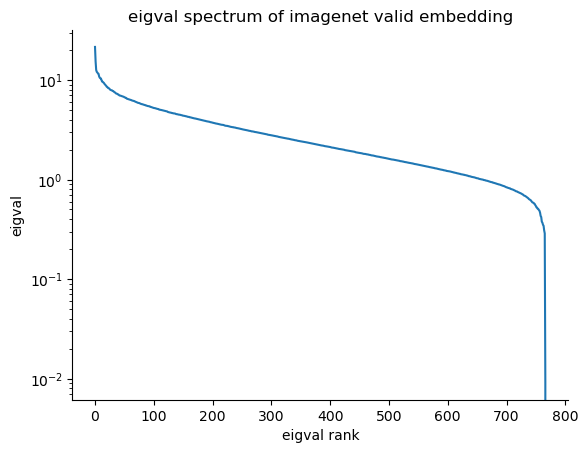

In [ ]:
plt.semilogy(IN_eigval.cpu().numpy())
plt.xlabel("eigval rank")
plt.ylabel("eigval")
plt.title("eigval spectrum of imagenet valid embedding")
plt.show()

### Frechet distance between image datasets

In [112]:
def compute_frechet_distance(mu1, mu2, cov1, cov2):
    a = (mu1 - mu2).square().sum(dim=-1)
    b = cov1.trace() + cov2.trace()
    c = torch.linalg.eigvals(cov1 @ cov2).sqrt().real.sum(dim=-1)
    return a + b - 2 * c

In [113]:
def compute_frechet_distance_terms(mu1, mu2, cov1, cov2):
    a = (mu1 - mu2).square().sum(dim=-1)
    b = cov1.trace() + cov2.trace()
    c = torch.linalg.eigvals(cov1 @ cov2).sqrt().real.sum(dim=-1)
    return a, (b - 2 * c)

In [114]:
list(embed_col.keys())

['imagenet_valid',
 'DeePSim_4std',
 'BigGAN_trunc07',
 'BigGAN_std_008',
 'BigGAN_1000cls_BG_orig',
 'BigGAN_1000cls_FC_invert',
 'BigGAN_1000cls_BG_blur',
 'resnet50_linf8_gradevol_fc',
 'resnet50_linf8_gradevol_avgpool',
 'resnet50_linf8_gradevol_layer4',
 'resnet50_linf8_gradevol_layer3',
 'pink_noise']

In [115]:
dataset_strs = list(embed_col.keys())
fid_col = {}
fid_terms_col = {}
for i in range(len(dataset_strs)):
    for j in range(i+1, len(dataset_strs)):
        dataset_str1, dataset_str2 = dataset_strs[i], dataset_strs[j]
        mu1, cov1 = mu_cov_col[dataset_str1]
        mu2, cov2 = mu_cov_col[dataset_str2]
        fid = compute_frechet_distance(mu1, mu2, cov1, cov2)
        fid_mean, fid_cov = compute_frechet_distance_terms(mu1, mu2, cov1, cov2)
        print(f"{dataset_str1} vs {dataset_str2} : {fid:.0f} (m {fid_mean:.0f} cov {fid_cov:.0f})")
        fid_col[(dataset_str1, dataset_str2)] = fid.cpu().item()
        fid_terms_col[(dataset_str1, dataset_str2)] = fid_mean.cpu().item(), fid_cov.cpu().item()

imagenet_valid vs DeePSim_4std : 1887 (m 863 cov 1024)
imagenet_valid vs BigGAN_trunc07 : 279 (m 76 cov 203)
imagenet_valid vs BigGAN_std_008 : 736 (m 219 cov 517)
imagenet_valid vs BigGAN_1000cls_BG_orig : 297 (m 86 cov 212)
imagenet_valid vs BigGAN_1000cls_FC_invert : 1355 (m 604 cov 751)
imagenet_valid vs BigGAN_1000cls_BG_blur : 668 (m 256 cov 412)
imagenet_valid vs resnet50_linf8_gradevol_fc : 667 (m 238 cov 429)
imagenet_valid vs resnet50_linf8_gradevol_avgpool : 1038 (m 436 cov 602)
imagenet_valid vs resnet50_linf8_gradevol_layer4 : 1083 (m 480 cov 602)
imagenet_valid vs resnet50_linf8_gradevol_layer3 : 1396 (m 625 cov 772)
imagenet_valid vs pink_noise : 4143 (m 2194 cov 1950)
DeePSim_4std vs BigGAN_trunc07 : 1587 (m 663 cov 924)
DeePSim_4std vs BigGAN_std_008 : 1260 (m 532 cov 728)
DeePSim_4std vs BigGAN_1000cls_BG_orig : 1526 (m 636 cov 890)
DeePSim_4std vs BigGAN_1000cls_FC_invert : 538 (m 260 cov 278)
DeePSim_4std vs BigGAN_1000cls_BG_blur : 1520 (m 702 cov 818)
DeePSim_4std

In [117]:
import seaborn as sns
import pandas as pd
df = pd.DataFrame(fid_col.values(), index=pd.MultiIndex.from_tuples(fid_col.keys()), columns=["FID"])
df["FID_mean"] = [fid_terms_col[k][0] for k in fid_col.keys()]
df["FID_cov"] = [fid_terms_col[k][1] for k in fid_col.keys()]
# df["FID"] = df["FID"].map(lambda x: x.item())
os.makedirs(join(GANembed_root, "summary"), exist_ok=True)
df.to_csv(join(GANembed_root, "summary", "dataset_DINO_FID.csv"))

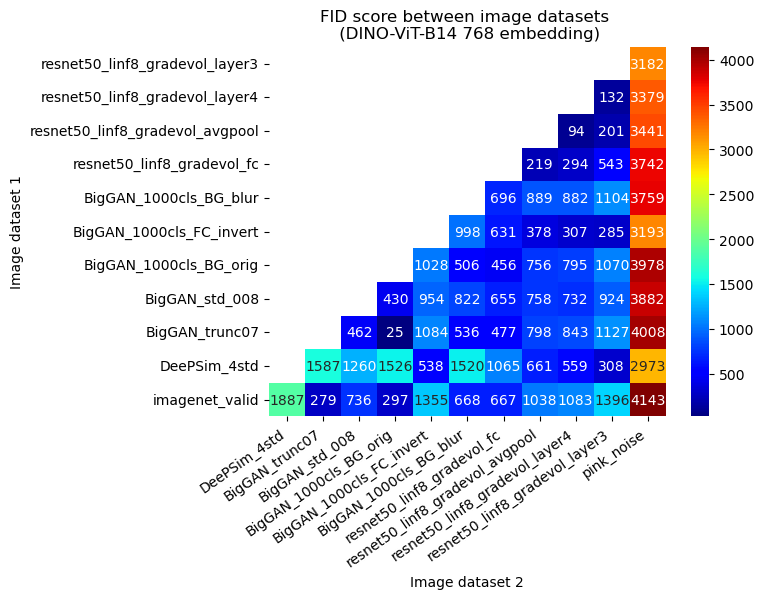

In [148]:
df_mat = df.reset_index().pivot(index="level_0", columns="level_1", values="FID", )
# order the row and column
df_mat_order = df_mat.loc[dataset_strs[:-1]][dataset_strs[1:]]
df_mat_order.to_csv(join(GANembed_root, "summary", "dataset_DINO_FID_ordmat.csv"))
# plot the FID score as distance matrix
sns.heatmap(df_mat_order, cmap="jet", annot=True, fmt=".0f")
# inver the y axis
plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()
# rotate the x axis label
plt.xticks(rotation=35, ha="right")
plt.xlabel("Image dataset 2")
plt.ylabel("Image dataset 1")
plt.title(f"FID score between image datasets \n (DINO-ViT-B14 {embed.shape[1]} embedding)")
saveallforms(join(GANembed_root, "summary"), "dataset_DINO_FID_ordmat")

In [127]:
df_mat_order

level_1,DeePSim_4std,BigGAN_trunc07,BigGAN_std_008,BigGAN_1000cls_BG_orig,BigGAN_1000cls_FC_invert,BigGAN_1000cls_BG_blur,resnet50_linf8_gradevol_fc,resnet50_linf8_gradevol_avgpool,resnet50_linf8_gradevol_layer4,resnet50_linf8_gradevol_layer3,pink_noise
level_0,,,,,,,,,,,
imagenet_valid,1887.429688,279.201172,735.897461,297.411621,1354.540283,667.990723,667.211426,1037.938232,1082.672363,1396.474121,4143.382324
DeePSim_4std,NaN,1586.994141,1260.204712,1525.920898,537.740234,1519.703003,1064.544067,661.201538,558.883423,307.994019,2972.873535
BigGAN_trunc07,NaN,NaN,461.817627,25.161621,1083.694092,536.236328,477.082275,798.473633,842.990479,1127.062988,4007.709473
BigGAN_std_008,NaN,NaN,NaN,429.568115,954.461182,821.944580,654.647217,758.030273,732.348877,923.846191,3882.492676
BigGAN_1000cls_BG_orig,NaN,NaN,NaN,NaN,1027.761475,505.798340,456.098145,755.839111,794.862061,1069.744141,3978.052734
BigGAN_1000cls_FC_invert,NaN,NaN,NaN,NaN,NaN,997.574707,631.211670,378.421631,307.424316,285.021240,3192.794434
BigGAN_1000cls_BG_blur,NaN,NaN,NaN,NaN,NaN,NaN,696.390381,888.777344,882.465088,1103.830566,3758.502441
resnet50_linf8_gradevol_fc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,219.484375,294.049561,543.006348,3742.162354
resnet50_linf8_gradevol_avgpool,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.250977,201.133789,3440.981445


* We can see by evolving from deeper layers of ResNet, the evolved image distribution deviates more and more from baseline distribution of DeePSim and approaches that of BigGAN / ImageNet. 
* BigGAN class sampling is the closest to ImageNet
* Unit guided evolution makes the statistics closer to ImageNet / BigGAN class than direct inversion (by minimizing pixel L2 loss). 

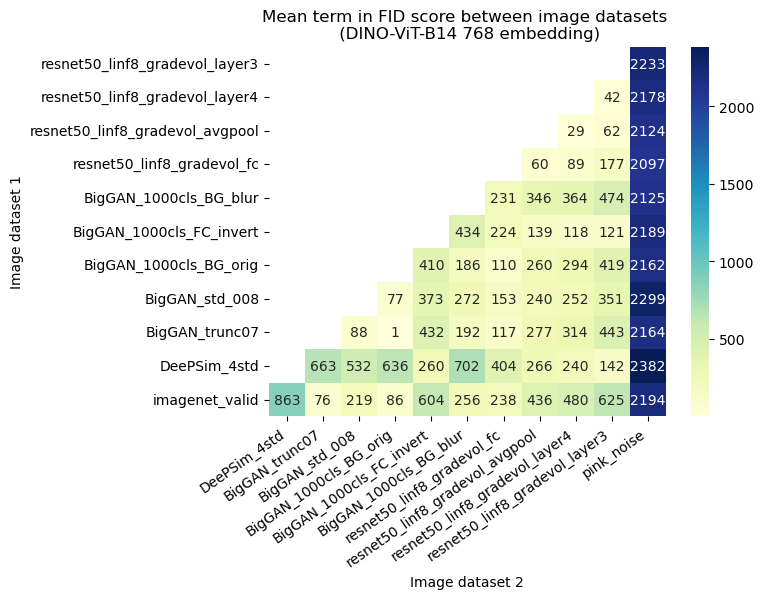

In [149]:
df_mat = df.reset_index().pivot(index="level_0", columns="level_1", values="FID_mean", )
# order the row and column
df_mat_order = df_mat.loc[dataset_strs[:-1]][dataset_strs[1:]]
# plot the FID score as distance matrix
sns.heatmap(df_mat_order, cmap="YlGnBu", annot=True, fmt=".0f")
# inver the y axis
plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()
# rotate the x axis label
plt.xticks(rotation=35, ha="right")
plt.xlabel("Image dataset 2")
plt.ylabel("Image dataset 1")
plt.title(f"Mean term in FID score between image datasets \n (DINO-ViT-B14 {embed.shape[1]} embedding)")
saveallforms(join(GANembed_root, "summary"), "dataset_DINO_FID_mean_ordmat")
df_mat_order.to_csv(join(GANembed_root, "summary", "dataset_DINO_FID_mean_ordmat.csv"))

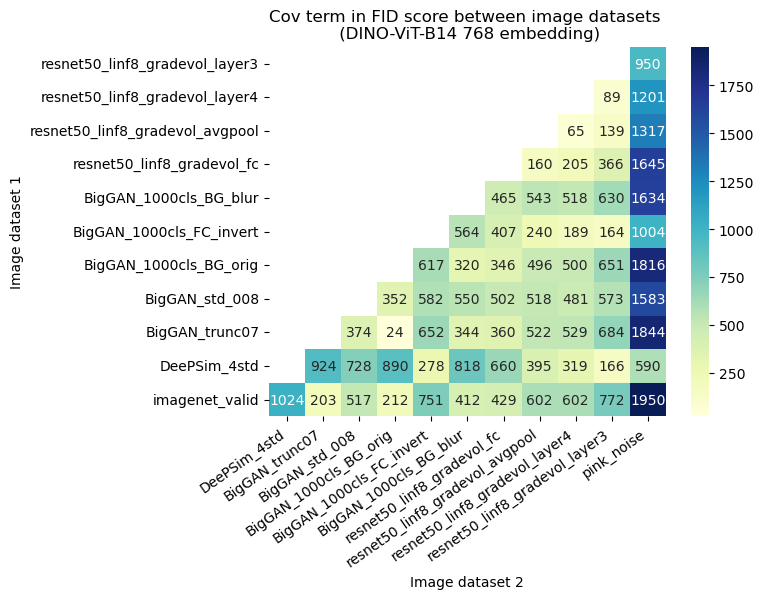

In [150]:
df_mat = df.reset_index().pivot(index="level_0", columns="level_1", values="FID_cov", )
# order the row and column
df_mat_order = df_mat.loc[dataset_strs[:-1]][dataset_strs[1:]]
# plot the FID score as distance matrix
sns.heatmap(df_mat_order, cmap="YlGnBu", annot=True, fmt=".0f")
# inver the y axis
plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()
# rotate the x axis label
plt.xticks(rotation=35, ha="right")
plt.xlabel("Image dataset 2")
plt.ylabel("Image dataset 1")
plt.title(f"Cov term in FID score between image datasets \n (DINO-ViT-B14 {embed.shape[1]} embedding)")
saveallforms(join(GANembed_root, "summary"), "dataset_DINO_FID_cov_ordmat")
df_mat_order.to_csv(join(GANembed_root, "summary", "dataset_DINO_FID_cov_ordmat.csv"))

### Dimensionality of image distributions (embeddings)

In [160]:
embed_eig_col = {}
for dataset_str in [
    "imagenet_valid",
    "DeePSim_4std",
    "BigGAN_trunc07",
    "BigGAN_std_008",
    "BigGAN_1000cls_BG_orig",
    "BigGAN_1000cls_FC_invert",
    "BigGAN_1000cls_BG_blur",
    "resnet50_linf8_gradevol_fc",
    "resnet50_linf8_gradevol_avgpool",
    "resnet50_linf8_gradevol_layer4",
    "resnet50_linf8_gradevol_layer3",
    "pink_noise",
]:
    if dataset_str == "imagenet_valid":
        embed = pkl.load(open(join(embed_dir, dataset_str+"_embedding.pkl"), "rb"))
    else:
        _, embed = pkl.load(open(join(embed_dir, dataset_str+"_embedding.pkl"), "rb"))
    embed = embed.cuda()
    cov = torch.cov(embed.T, )
    data_mean = embed.mean(dim=0)
    data_eigvals, data_eigvecs = torch.linalg.eigh(cov)
    data_eigvals = torch.flip(data_eigvals, dims=[0])
    data_eigvecs = torch.flip(data_eigvecs, dims=[1])
    embed_eig_col[dataset_str] = (data_mean, data_eigvals, data_eigvecs)

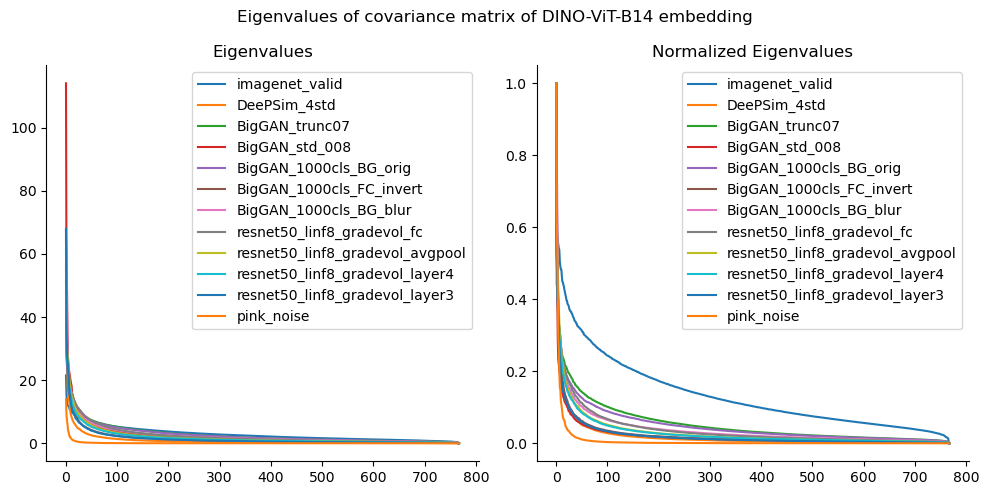

In [161]:
# plot the eigenvalues
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, dataset_str in enumerate(embed_eig_col):
    data_mean, data_eigvals, data_eigvecs = embed_eig_col[dataset_str]
    axes[0].plot(data_eigvals.detach().cpu().numpy(), label=dataset_str)
    axes[1].plot(data_eigvals.detach().cpu().numpy() / data_eigvals[0].detach().cpu().numpy(), label=dataset_str)
axes[0].legend()
axes[0].set_title("Eigenvalues")
axes[1].legend()
axes[1].set_title("Normalized Eigenvalues")
plt.suptitle(f"Eigenvalues of covariance matrix of DINO-ViT-B14 embedding")
plt.tight_layout()
saveallforms(join(GANembed_root, "summary"), "dataset_DINO_FID_eigvals")


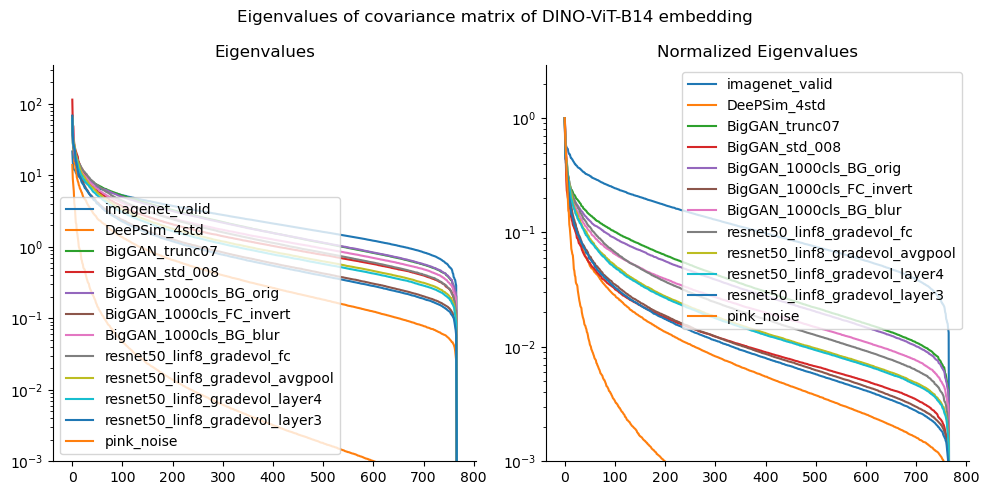

In [162]:
# plot the eigenvalues
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, dataset_str in enumerate(embed_eig_col):
    data_mean, data_eigvals, data_eigvecs = embed_eig_col[dataset_str]
    axes[0].semilogy(data_eigvals.detach().cpu().numpy(), label=dataset_str)
    axes[1].semilogy(data_eigvals.detach().cpu().numpy() / data_eigvals[0].detach().cpu().numpy(), label=dataset_str)
axes[0].legend()
axes[0].set_title("Eigenvalues")
axes[1].legend()
axes[1].set_title("Normalized Eigenvalues")
axes[0].set_ylim(1e-3, None)
axes[1].set_ylim(1e-3, None)
plt.suptitle(f"Eigenvalues of covariance matrix of DINO-ViT-B14 embedding")
plt.tight_layout()
saveallforms(join(GANembed_root, "summary"), "dataset_DINO_FID_eigvals_logy")

* We can see the dimensionality of the ImageNet validation set is still the largest among all! i.e. the most diverse dataset than the generated ones. 
* Synthetic image still lack in their variability comparing to natural ones
* The spectrum (effective dim) of embeddings could be a indicator of image diversity / quality?

In [163]:

# print the dimesnionality of the embedding
eigcnt = 100
print(f"Dimensionality of the embedding : Explained variance of top {eigcnt} PCs")
ratios = {}
for dataset_str in embed_eig_col:
    data_mean, data_eigvals, data_eigvecs = embed_eig_col[dataset_str]
    participation_ratio = data_eigvals[:100].sum() / data_eigvals.sum()
    print(dataset_str, participation_ratio.item())
    ratios[dataset_str] = participation_ratio.item()


Dimensionality of the embedding : Explained variance of top 100 PCs
imagenet_valid 0.33422747254371643
DeePSim_4std 0.6748373508453369
BigGAN_trunc07 0.4330815076828003
BigGAN_std_008 0.5640898942947388
BigGAN_1000cls_BG_orig 0.43473535776138306
BigGAN_1000cls_FC_invert 0.6070705652236938
BigGAN_1000cls_BG_blur 0.4983849823474884
resnet50_linf8_gradevol_fc 0.5260428190231323
resnet50_linf8_gradevol_avgpool 0.5646798014640808
resnet50_linf8_gradevol_layer4 0.5608787536621094
resnet50_linf8_gradevol_layer3 0.6091912388801575
pink_noise 0.944559633731842


In [165]:
# sort dataset names by ratios
sorted_ratios = sorted(ratios.items(), key=lambda x: x[1], reverse=False)
sorted_ratios

[('imagenet_valid', 0.33422747254371643),
 ('BigGAN_trunc07', 0.4330815076828003),
 ('BigGAN_1000cls_BG_orig', 0.43473535776138306),
 ('BigGAN_1000cls_BG_blur', 0.4983849823474884),
 ('resnet50_linf8_gradevol_fc', 0.5260428190231323),
 ('resnet50_linf8_gradevol_layer4', 0.5608787536621094),
 ('BigGAN_std_008', 0.5640898942947388),
 ('resnet50_linf8_gradevol_avgpool', 0.5646798014640808),
 ('BigGAN_1000cls_FC_invert', 0.6070705652236938),
 ('resnet50_linf8_gradevol_layer3', 0.6091912388801575),
 ('DeePSim_4std', 0.6748373508453369),
 ('pink_noise', 0.944559633731842)]

## Distance of Evolved images to Reference distributions

In [166]:
# compute mahalanobis distance
def mahalanobis_sqdist(x, mean, eigvec, eigval, eigfloor=1e-5):
    x = x - mean[None, :]
    # rotate
    rot_x = x @ eigvec
    # scale
    return (rot_x ** 2 / torch.clamp(eigval[None, :], min=eigfloor)).sum(dim=1)

In [167]:
# plot functions to collect activation / distace according to gens. 
def compute_mean_var(x, gen_vec, var="std"):
    meanvec = []
    errvec = []
    for gen in range(gen_vec.min(), gen_vec.max()+1):
        meanvec.append(x[gen_vec==gen].mean())
        if var == "std":
            errvec.append(x[gen_vec==gen].std())
        elif var == "var":
            errvec.append(x[gen_vec==gen].var())
        elif var == "sem":
            errvec.append(x[gen_vec==gen].std() / np.sqrt((gen_vec==gen).sum()))
    return torch.tensor(meanvec), torch.tensor(errvec)

def plot_shaded_errorbar(x, y, color="b", label="", var="std", **kwargs):
    meanvec, errvec = compute_mean_var(y, x, var=var)
    plt.plot(np.unique(x), meanvec, color=color, label=label, **kwargs)
    plt.fill_between(np.unique(x), meanvec-errvec, meanvec+errvec, color=color, alpha=0.3)

In [170]:
def load_compute_eigen(dataset_str):
    if dataset_str == "imagenet_valid":
        embed = pkl.load(open(join(GANembed_dir, dataset_str+"_embedding.pkl"), "rb"))
    else:
        _, embed = pkl.load(open(join(GANembed_dir, dataset_str+"_embedding.pkl"), "rb"))
    embed = embed.cuda()
    cov = torch.cov(embed.T, )
    data_mean = embed.mean(dim=0)
    data_eigvals, data_eigvecs = torch.linalg.eigh(cov)
    data_eigvals = torch.flip(data_eigvals, dims=[0])
    data_eigvecs = torch.flip(data_eigvecs, dims=[1])
    return (data_mean, data_eigvals, data_eigvecs)

In [174]:
# FC_mean, FC_eigvals, FC_eigvecs = load_compute_eigen("DeePSim_4std")
# BG_mean, BG_eigvals, BG_eigvecs = load_compute_eigen("BigGAN_trunc07")
# BGRND_mean, BGRND_eigvals, BGRND_eigvecs = load_compute_eigen("BigGAN_std_008")
# IN_mean, IN_eigvals, IN_eigvecs = load_compute_eigen("imagenet_valid")
MH_eig_col = {}
for dataset_str in [
    "DeePSim_4std",
    "BigGAN_trunc07",
    "BigGAN_std_008",
    "imagenet_valid"
]:
    MH_eig_col[dataset_str] = load_compute_eigen(dataset_str)

In [135]:
import glob
embed_root = "/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/BigGAN_img_embedding"
Evol_embed_dir = join(embed_root, "dinov2_vitb14")
print(Evol_embed_dir)
# count number of files in the directory
num_files = len(glob.glob(join(Evol_embed_dir, "*")))
print(num_files)

/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/BigGAN_img_embedding/dinov2_vitb14
170


In [177]:
Evol_embed_dir
embed_dir

'/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/GAN_img_embedding/dinov2_vitb14'

In [179]:
os.path.exists(join(Evol_embed_dir, f"Exp{Expi}_embed_act_data.pkl"))

True

In [200]:
Evol_embed_dir

'/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/BigGAN_img_embedding/dinov2_vitb14'

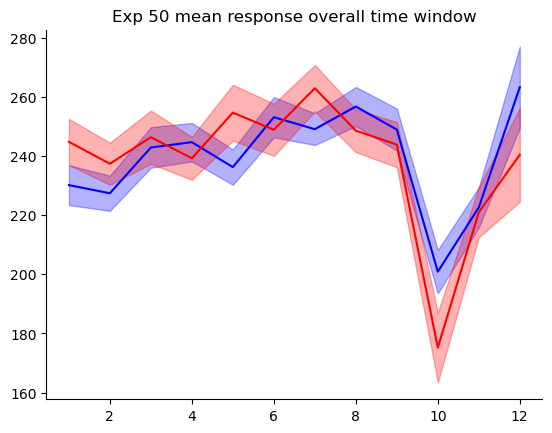

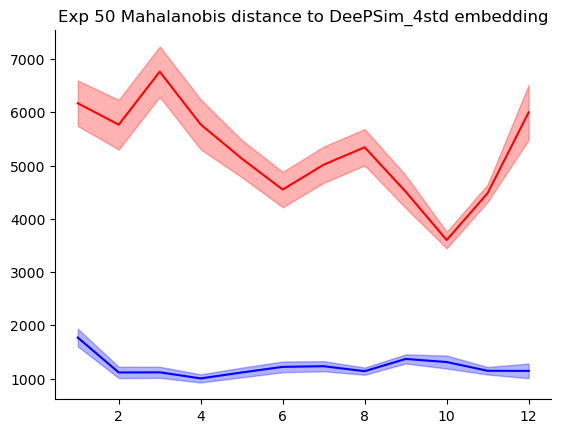

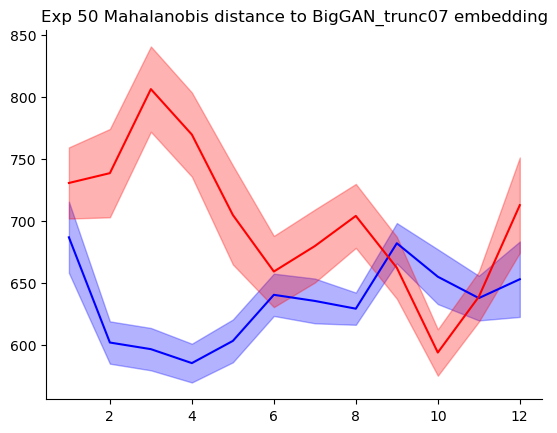

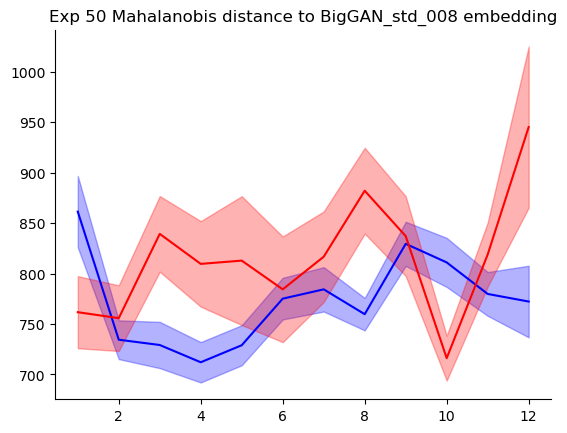

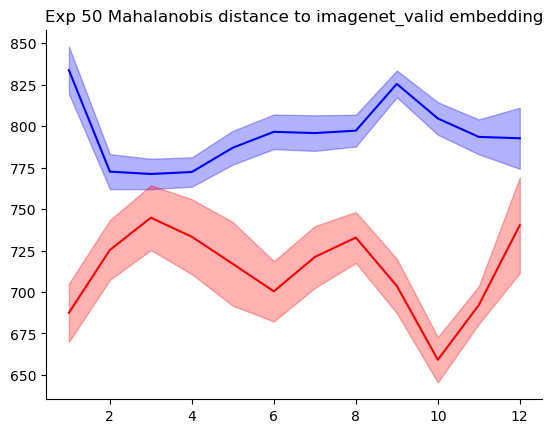

In [199]:
# Expi = 184
for Expi in [50]:#tqdm(range(1, 190+1)):
    # if ~ os.path.exists(join(Evol_embed_dir, f"Exp{Expi}_embed_act_data.pkl")):
    #     continue
    Evol_data = pkl.load(open(join(Evol_embed_dir, f"Exp{Expi:03d}_embed_act_data.pkl"), "rb"))
    embeddings0 = Evol_data["embeddings0"]
    embeddings1 = Evol_data["embeddings1"]
    imgfps0 = Evol_data["imgfps0"]
    imgfps1 = Evol_data["imgfps1"]
    resp_mat0 = Evol_data["resp_mat0"]
    resp_mat1 = Evol_data["resp_mat1"]
    gen_vec0 = Evol_data["gen_vec0"]
    gen_vec1 = Evol_data["gen_vec1"]
    # MHdist_0 = mahalanobis_sqdist(embeddings0, IN_mean, IN_eigvec, IN_eigval, eigfloor=1e-2)
    # MHdist_1 = mahalanobis_sqdist(embeddings1, IN_mean, IN_eigvec, IN_eigval, eigfloor=1e-2)
    plt.figure()
    plot_shaded_errorbar(gen_vec0, resp_mat0[:, 0], color="b", label="thread 0", var="sem")
    plot_shaded_errorbar(gen_vec1, resp_mat1[:, 0], color="r", label="thread 1", var="sem")
    plt.title(f"Exp {Expi} mean response overall time window")
    plt.show()
    for dataset_str in MH_eig_col:
        data_mean, data_eigvals, data_eigvecs = MH_eig_col[dataset_str]
        MHdist_0 = mahalanobis_sqdist(embeddings0.cuda(), data_mean, data_eigvecs, data_eigvals, eigfloor=1e-3).cpu()
        MHdist_1 = mahalanobis_sqdist(embeddings1.cuda(), data_mean, data_eigvecs, data_eigvals, eigfloor=1e-3).cpu()
        # Evol_data[f"MHdist_{dataset_str}_0"] = MHdist_0
        # Evol_data[f"MHdist_{dataset_str}_1"] = MHdist_1
        plt.figure()
        plot_shaded_errorbar(gen_vec0, MHdist_0, color="b", label="thread 0", var="sem")
        plot_shaded_errorbar(gen_vec1, MHdist_1, color="r", label="thread 1", var="sem")
        plt.title(f"Exp {Expi} Mahalanobis distance to {dataset_str} embedding")
        plt.show()

In [124]:
Expi = 184
Evol_data = pkl.load(open(join(embed_dir, f"Exp{Expi}_embed_act_data.pkl"), "rb"))
embeddings0 = Evol_data["embeddings0"]
embeddings1 = Evol_data["embeddings1"]
imgfps0 = Evol_data["imgfps0"]
imgfps1 = Evol_data["imgfps1"]
resp_mat0 = Evol_data["resp_mat0"]
resp_mat1 = Evol_data["resp_mat1"]
gen_vec0 = Evol_data["gen_vec0"]
gen_vec1 = Evol_data["gen_vec1"]

In [125]:
MHdist_0 = mahalanobis_sqdist(embeddings0, IN_mean, IN_eigvec, IN_eigval, eigfloor=1e-2)
MHdist_1 = mahalanobis_sqdist(embeddings1, IN_mean, IN_eigvec, IN_eigval, eigfloor=1e-2)

In [126]:
# t test on the mahalanobis distance for gen 1 and last gen 
from scipy.stats import ttest_ind
print(ttest_ind(MHdist_0[gen_vec0<=3], MHdist_0[gen_vec0>=gen_vec0.max()-2]))
print(ttest_ind(MHdist_1[gen_vec1<=2], MHdist_1[gen_vec1>=gen_vec1.max()-1]))

TtestResult(statistic=-0.802136447658736, pvalue=0.4234761621072264, df=190.0)
TtestResult(statistic=-5.35593181215439, pvalue=7.965883259394371e-07, df=80.0)


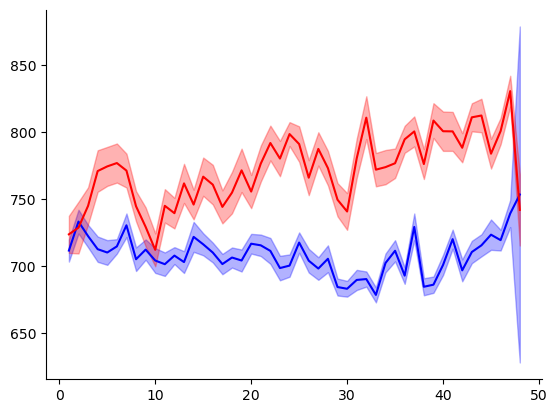

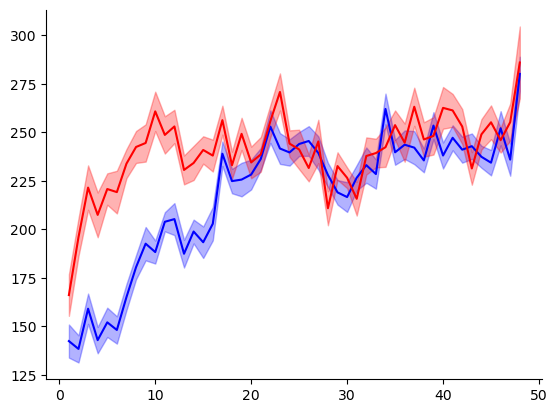

In [128]:
plt.figure()
plot_shaded_errorbar(gen_vec0, MHdist_0, color="b", label="thread 0", var="sem")
plot_shaded_errorbar(gen_vec1, MHdist_1, color="r", label="thread 1", var="sem")
plt.show()

plt.figure()
plot_shaded_errorbar(gen_vec0, resp_mat0[:, 0], color="b", label="thread 0", var="sem")
plot_shaded_errorbar(gen_vec1, resp_mat1[:, 0], color="r", label="thread 1", var="sem")
plt.show()

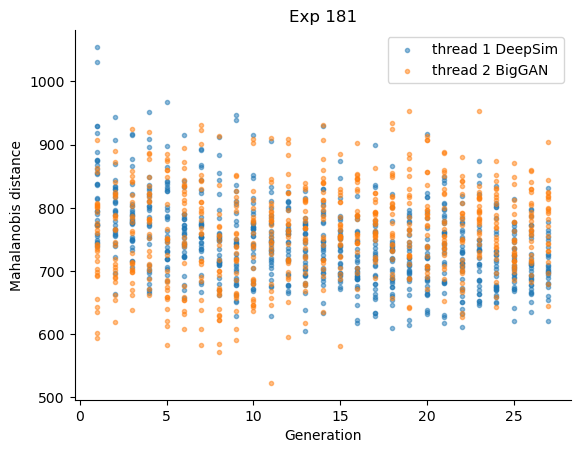

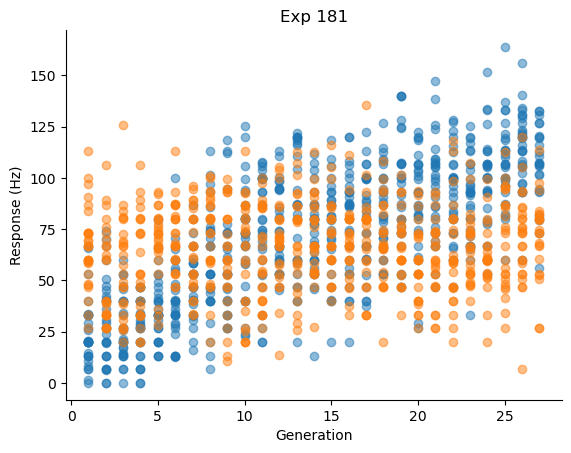

In [123]:
plt.plot(gen_vec0[:,],resp_mat0[:, 0], "o", alpha=0.5)
plt.plot(gen_vec1[:,],resp_mat1[:, 0], "o", alpha=0.5)
plt.xlabel("Generation")
plt.ylabel("Response (Hz)")
plt.title(f"Exp {Expi}")
plt.show()

plt.scatter(gen_vec0, MHdist_0, label="thread 1 DeepSim", marker=".", alpha=0.5)
plt.scatter(gen_vec1, MHdist_1, label="thread 2 BigGAN", marker=".", alpha=0.5)
plt.legend()
plt.xlabel("Generation")
plt.ylabel("Mahalanobis distance")
plt.title(f"Exp {Expi}")
plt.show()

## Scratch zone 

In [ ]:
# Define the response time windows
# rsp_wdws += [range(strt, strt+25) for strt in range(0, 200, 25)]
# get image sequence and response in different time windows
# image paths: (n_images, )
# response: (n_images, n_time)
Expi = 155
Expi = 165
imgfps0, resp_mat0, gen_vec0 = load_img_resp_pairs_multiwindow(BFEStats, Expi,
                         "Evol", thread=0, stimdrive=stim_rootdir,
                        output_fmt="vec", rsp_wdws=rsp_wdws)
imgfps1, resp_mat1, gen_vec1 = load_img_resp_pairs_multiwindow(BFEStats, Expi,
                         "Evol", thread=1, stimdrive=stim_rootdir,
                         output_fmt="vec", rsp_wdws=rsp_wdws)

In [ ]:
embeddings0, dataset0 = embed_imgs(imgfps0, embed_model, batch_size=100, size=224, device=device)
embeddings1, dataset1 = embed_imgs(imgfps1, embed_model, batch_size=100, size=224, device=device)

In [ ]:
dataset = ImagePathDataset(imgfps0, transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalizer,
]))
dataloader = DataLoader(dataset, batch_size=100, shuffle=False, num_workers=0)


In [ ]:
embed_model = embed_model.cuda()
embed_model.eval()
embeddings = []
for batch, _ in tqdm(dataloader):
    batch = batch.cuda()
    with torch.no_grad():
        embed_vec = embed_model(batch)
    embeddings.append(embed_vec)
embeddings = torch.cat(embeddings, dim=0)


In [ ]:
Expi = 184
embed_dir2 = join(embed_root, "dinov2_vitb14_local")
Evol_data2 = pkl.load(open(join(embed_dir2, f"Exp{Expi}_embed_act_data.pkl"), "rb"))
Evol_data = pkl.load(open(join(embed_dir, f"Exp{Expi}_embed_act_data.pkl"), "rb"))
# compare embeddings
assert torch.allclose(Evol_data["embeddings0"], Evol_data2["embeddings0"], atol=1e-3, rtol=1e-3)
assert torch.allclose(Evol_data["embeddings1"], Evol_data2["embeddings1"], atol=1e-3, rtol=1e-3)

AssertionError: 

In [ ]:
Evol_data["embeddings0"].abs().sum()

tensor(1617812.6250)

In [ ]:
(Evol_data2["embeddings0"] - Evol_data["embeddings0"]).abs().sum()

tensor(2570.2437)

In [ ]:
Evol_data["embeddings0"]

tensor([[ 0.1951,  0.4970,  1.3513,  ..., -0.0663,  0.2268, -1.2306],
        [-0.7044, -1.0375,  1.1795,  ..., -2.3465, -2.0538, -1.3802],
        [-0.4620,  0.0822,  0.5605,  ..., -1.1973,  1.8351, -2.0165],
        ...,
        [ 2.2823,  0.7341,  1.8795,  ...,  0.2762,  0.5284,  0.2757],
        [ 1.9710,  0.8025,  1.4064,  ...,  0.0788,  0.7820,  0.7175],
        [ 2.6020,  0.1914,  2.2508,  ..., -0.1077, -1.4906,  0.9322]])